In [1]:
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import parselmouth as pm
from scipy.io.wavfile import read as read_wav
from parselmouth.praat import call
import pyaudio
import wave
from tqdm.notebook import tqdm
sns.set() # Use seaborn's default style to make attractive graphs
plt.rcParams['figure.dpi']

72.0

In [3]:
sound = read_wav('fragment.wav')

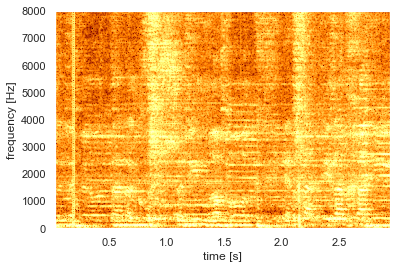

In [15]:
# If desired, pre-emphasize the sound fragment before calculating the spectrogram
pre_emphasized_snd = snd.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)
plt.figure()
draw_spectrogram(spectrogram)


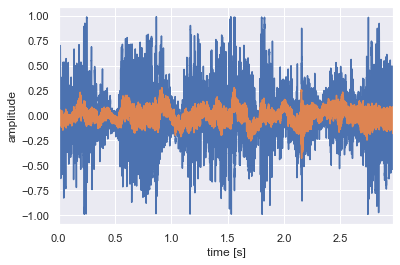

In [9]:
snd = pm.Sound('fragment.wav')
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show()

<h3 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Utilities and Helper Functions</h3>


In [10]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")
def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

# pitch = snd.to_pitch()
# # If desired, pre-emphasize the sound fragment before calculating the spectrogram
# pre_emphasized_snd = snd.copy()
# pre_emphasized_snd.pre_emphasize()
# spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)
# plt.figure()
# draw_spectrogram(spectrogram)
# plt.twinx()
# draw_pitch(pitch)
# plt.xlim([snd.xmin, snd.xmax])
# plt.show()

In [92]:
def calculate_sound_features(snd):
    #Calculate A Bulck of prrat features simmilar to what we saw in MIT's paper 
    pitch     = snd.to_pitch().selected_array['frequency']
    intensity = snd.to_intensity().values
    max_pitch = np.max(pitch)
    min_pitch = np.min(pitch)
    mean_pitch = np.mean(pitch)
    diffPitchMaxMean = max_pitch-mean_pitch
    intensityMean = np.mean(intensity)
    intensityMax = np.max(intensity)
    intensityMin = np.min(intensity)
    broad_pitch = call(snd, "To Pitch", 0.0, 50, 600) #create a praat pitch object
    minF0 = call(broad_pitch, "Get minimum", 0, 0, "hertz", "Parabolic") # get min pitch
    maxF0 = call(broad_pitch, "Get maximum", 0, 0, "hertz", "Parabolic")  # get max pitch
    floor = minF0 * 0.9
    ceiling = maxF0 * 1.1
    pitch = call(snd, "To Pitch", 0.0, floor, ceiling)  # create a praat pitch object
    duration = call(snd, "Get total duration") # duration
    meanF0 = call(pitch, "Get mean", 0, 0, "hertz") # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, "hertz") # get standard deviation
    harmonicity = call(snd, "To Harmonicity (cc)", 0.01, minF0, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(snd, "To PointProcess (periodic, cc)", minF0, maxF0)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    if meanF0 > 170 and meanF0 < 300:
        max_formant = 5500
    elif meanF0 <=170:
        max_formant = 5000
    elif meanF0 >= 300:
        max_formant = 8000
        
    formants = call(sound, "To Formant (burg)", 0.0025, 5, max_formant, 0.025, 50)
    numPoints = call(pointProcess, "Get number of points")
    f1_list = []
    f2_list = []
    f3_list = []
    f4_list = []
    for point in range(0, numPoints):
        point += 1
        t = call(pointProcess, "Get time from index", point)
        f1 = call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
        f2 = call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
        f3 = call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
        f4 = call(formants, "Get value at time", 4, t, 'Hertz', 'Linear')
        f1_list.append(f1)
        f2_list.append(f2)
        f3_list.append(f3)
        f4_list.append(f4)
        f1_list.append(f1)
        f2_list.append(f2)
        f3_list.append(f3)
        f4_list.append(f4)
        
    
    #return relvent to us feature *delete later those that have no use
    result_dict = {'intensityMax':intensityMax,
                   'intensityMin':intensityMin,
                   'intensityMean':intensityMean,
                   'PitchMax':max_pitch,
                   'PitchMin':min_pitch,
                   'PitchMean':mean_pitch,
                   'F1_STD':np.std(f1_list),
                   'F3_STD':np.std(f3_list),
                   'F2_STD_F1':np.std(f2_list)/np.std(f1_list)}
    return result_dict
        
    

In [140]:
def recored_audio(rec_time,fragmentize=2,output_path='',file_name='output.wav'):
    
    """
    Parameters
    ----------
    rec_time : int
        The number of secondes the function will recored 
    output_path : str
        where to save the recording
    file_name : str
        the name of the saved file followed by .wav
    fragmentize : int
        every x seconds save a fragment.wav file of the last x seconds in the recording
    """

    
    #=====================WAV Audio Format Static Variables ============================
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 2
    RATE = 44100
    RECORD_SECONDS = rec_time
    WAVE_OUTPUT_FILENAME = output_path+file_name

    
    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("* recording")

    frames = []
    segment = []

    for i in tqdm(range(0, int(RATE / CHUNK * RECORD_SECONDS)),position =0):
        data = stream.read(CHUNK)
        frames.append(data)
        if i%(int(RATE / CHUNK*fragmentize)) != 0:
            segment.append(data)
        else:
            print('# fragment saved')
            wf = wave.open(output_path+'fragment.wav', 'wb')
            wf.setnchannels(CHANNELS)
            wf.setsampwidth(p.get_sample_size(FORMAT))
            wf.setframerate(RATE)
            wf.writeframes(b''.join(frames))
            wf.close()
            segment = []

    print("* done recording")

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

<h3 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Start Of Pipline \ Playground</h3>


In [141]:
calculate_sound_features(snd)

{'intensityMax': 87.29916095001568,
 'intensityMin': 9.557054906711777,
 'intensityMean': 65.29981394364263,
 'PitchMax': 296.1721536573829,
 'PitchMin': 0.0,
 'PitchMean': 132.04390295706563,
 'F1_STD': 271.99656889588783,
 'F3_STD': 236.40790715960796,
 'F2_STD_F1': 1.3927190720893396}

In [146]:
pd.Series(calculate_sound_features(snd).keys(),name='features').to_frame()

,features
0,intensityMax
1,intensityMin
2,intensityMean
3,PitchMax
4,PitchMin
5,PitchMean
6,F1_STD
7,F3_STD
8,F2_STD_F1


In [142]:
recored_audio(6,2)

* recording


# fragment saved
# fragment saved
# fragment saved

* done recording
